# Pyfolio
<br>
Pyfolio是一個用於金融投資組合績效與風險分析的 Python 庫，主要以圖表方式顯示投資策略的優劣，它與 Zipline-tej 開源回測庫完美兼容。本次實例將以布林通道交易策略為例，向您介紹 Pyfolio 所提供的強大視覺化與績效風險分析功能。

### 載入所需套件與股價資料

In [1]:
import os 
import pandas as pd 
import numpy as np 
import tejapi

os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'
os.environ['TEJAPI_KEY'] = 'Your_key'
os.environ['mdate'] = '20050702 20230702'
os.environ['ticker'] = 'IR0001 2330 2303 3443 2369 3414 2337 2454 2451 2388 3711 6770 1101 1701 1734 4133 2201 2206 1201'

!zipline ingest -b tquant

Merging daily equity files:


[2023-11-30 11:01:44.902664] INFO: zipline.data.bundles.core: Ingesting tquant.


### 交易策略撰寫

In [2]:
from zipline.api import set_slippage, set_commission, set_benchmark, attach_pipeline, order, order_target, symbol, pipeline_output, record
from zipline.finance import commission, slippage
from zipline.data import bundles
from zipline import run_algorithm
from zipline.pipeline import Pipeline
from zipline.pipeline.filters import StaticAssets, StaticSids
from zipline.pipeline.factors import BollingerBands
from zipline.pipeline.data import EquityPricing

bundle = bundles.load('tquant')
ir0001_asset = bundle.asset_finder.lookup_symbol('IR0001',as_of_date = None)

def make_pipeline():
    
    perf = BollingerBands(inputs=[EquityPricing.close], window_length=20, k=2)
    upper,middle,lower = perf.upper,perf.middle, perf.lower
    curr_price = EquityPricing.close.latest
     
    return Pipeline(
        columns = {
            'upper':  upper,
            'middle':  middle,
            'lower':  lower,
            'curr_price':curr_price
        },
        screen = ~StaticAssets([ir0001_asset])
    )

def initialize(context):
    context.last_buy_price = 0
    set_commission(commission.PerShare(cost=0.00285))
    set_benchmark(symbol('IR0001'))
    attach_pipeline(make_pipeline(), 'mystrategy')
    context.last_signal_price = 0
    
def handle_data(context, data):
    out_dir = pipeline_output('mystrategy')
    for i in out_dir.index: 
        sym = i.symbol # 標的代碼
        upper = out_dir.loc[i, 'upper']
        middle = out_dir.loc[i, 'middle']
        lower = out_dir.loc[i, 'lower']
        curr_price = out_dir.loc[i, 'curr_price']
        cash_position = context.portfolio.cash
        stock_position = context.portfolio.positions[i].amount
        
        buy, sell = False, False
        
        record(
            **{
                f'price_{sym}':curr_price,
                f'upper_{sym}':upper,
                f'lower_{sym}':lower,
                f'buy_{sym}':buy,
                f'sell_{sym}':sell
            }
        )
        
        if stock_position == 0:
            if (curr_price <= lower) and (cash_position >= curr_price * 1000):
                order(i, 1000)
                context.last_signal_price = curr_price
                buy = True
                record(
                    **{
                        f'buy_{sym}':buy
                    }
                )
        elif stock_position > 0:
            if (curr_price <= lower) and (curr_price <= context.last_signal_price) and (cash_position >= curr_price * 1000):
                order(i, 1000)
                context.last_signal_price = curr_price
                buy = True
                record(
                    **{
                        f'buy_{sym}':buy
                    }
                )
            elif (curr_price >= upper):
                order_target(i, 0)
                context.last_signal_price = 0
                sell = True
                record(
                    **{
                        f'sell_{sym}':sell
                    }
                )
            else:
                pass
        else:
            pass

def analyze(context, perf):
    pass

results = run_algorithm(
    start = pd.Timestamp('2008-07-02', tz='UTC'),
    end = pd.Timestamp('2022-07-02', tz ='UTC'),
    initialize=initialize,
    bundle='tquant',
    analyze=analyze,
    capital_base=5e4,
    handle_data = handle_data
)

results

,period_open,period_close,orders,starting_cash,ending_cash,ending_exposure,portfolio_value,longs_count,shorts_count,long_value,...,price_3711,upper_3711,lower_3711,buy_3711,sell_3711,price_6770,upper_6770,lower_6770,buy_6770,sell_6770
2008-07-02 13:30:00+08:00,2008-07-02 09:01:00+08:00,2008-07-02 13:30:00+08:00,"[{'id': '595be706aa2343768b1371e59e9d11ba', 'd...",50000.000000,50000.000000,0.0,50000.000000,0,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-07-03 13:30:00+08:00,2008-07-03 09:01:00+08:00,2008-07-03 13:30:00+08:00,"[{'id': '595be706aa2343768b1371e59e9d11ba', 'd...",50000.000000,20132.225000,29850.0,49982.225000,1,0,29850.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-07-04 13:30:00+08:00,2008-07-04 09:01:00+08:00,2008-07-04 13:30:00+08:00,[],20132.225000,20132.225000,29350.0,49482.225000,1,0,29350.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-07-07 13:30:00+08:00,2008-07-07 09:01:00+08:00,2008-07-07 13:30:00+08:00,[],20132.225000,20132.225000,28950.0,49082.225000,1,0,28950.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-07-08 13:30:00+08:00,2008-07-08 09:01:00+08:00,2008-07-08 13:30:00+08:00,"[{'id': 'ab385396300f4b8a9ba4847dc56f4dbe', 'd...",20132.225000,20132.225000,28300.0,48432.225000,1,0,28300.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-27 13:30:00+08:00,2022-06-27 09:01:00+08:00,2022-06-27 13:30:00+08:00,[],16127.836515,16127.836515,196650.0,212777.836515,5,0,196650.0,...,92.000000,108.117111,93.722889,False,False,43.00,62.067993,43.267007,False,False
2022-06-28 13:30:00+08:00,2022-06-28 09:01:00+08:00,2022-06-28 13:30:00+08:00,[],16127.836515,16127.836515,195150.0,211277.836515,5,0,195150.0,...,94.300000,108.338264,92.831736,False,False,44.25,61.959640,42.150360,False,False
2022-06-29 13:30:00+08:00,2022-06-29 09:01:00+08:00,2022-06-29 13:30:00+08:00,[],16127.836515,16127.836515,188800.0,204927.836515,5,0,188800.0,...,84.004017,100.339545,84.256975,False,False,42.80,61.565388,41.014612,False,False
2022-06-30 13:30:00+08:00,2022-06-30 09:01:00+08:00,2022-06-30 13:30:00+08:00,[],16127.836515,16127.836515,180300.0,196427.836515,5,0,180300.0,...,79.100000,101.074173,81.785732,False,False,41.70,61.110869,39.859131,False,False


<span id="menu"></span>
## Pyfolio 函式選單

* [extract_rets_pos_txn_from_zipline](#extract_rets_pos_txn_from_zipline)
* [show_perf_stats](#show_perf_stats)
* [show_worst_drawdown_periods](#show_worst_drawdown_periods)
* [create_interesting_times_tear_sheet](#create_interesting_times_tear_sheet)
* [show_and_plot_top_positions](#show_and_plot_top_positions)
* [get_percent_alloc](#get_percent_alloc)
* [plot_rolling_retruns](#plot_rolling_retruns)
* [plot_returns](#plot_returns)
* [plot_rolling_beta](#plot_rolling_beta)
* [plot_rolling_volatility](#plot_rolling_volatility)
* [plot_rolling_sharpe](#plot_rolling_sharpe)
* [plot_drawdown_periods](#plot_drawdown_periods)
* [plot_drawdown_underwater](#plot_drawdown_underwater)
* [plot_monthly_returns_heatmap](#plot_monthly_returns_heatmap)
* [plot_annual_returns](#plot_annual_returns)
* [plot_monthly_returns_dist](#plot_monthly_returns_dist)
* [plot_return_quantiles](#plot_return_quantiles)
* [plot_exposures](#plot_exposures)
* [plot_max_median_position_concentration](#plot_max_median_position_concentration)
* [plot_holdings](#plot_holdings)
* [plot_long_short_holdings](#plot_long_short_holdings)
* [plot_gross_leverage](#plot_gross_leverage)
* [plot_turnover](#plot_turnover)
* [plot_daily_volume](#plot_daily_volume)
* [plot_daily_turnover_hist](#plot_daily_turnover_hist)
* [plot_txn_time_hist](#plot_txn_time_hist)
* [create_full_tear_sheet](#create_full_tear_sheet)

<span id="extract_rets_pos_txn_from_zipline"></span>
### pyfolio.utils.extract_rets_pos_txn_from_zipline

用於從 `zipline.run_algorithms()` 所輸出的資料表中，提取交易策略報酬、持有部位與交易資訊。

#### Parameters:
* backtest: pd.DataFrame<br>
        zipline.run_algorithm() 得出的資料表。
    
#### Returns:
* returns: _pd.Series_<br>
        交易策略的每日報酬。
* positions: _pd.DataFrame_<br>
        交易策略的各證券與現金每日持有部位。
* transactions : _pd.DataFrame_<br>
        交易策略的每日交易資料，一列為一筆交易。
        
[Return to Menu](#menu)

In [3]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline

returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# 時區標準化
returns.index = returns.index.tz_localize(None).tz_localize('UTC')
positions.index = positions.index.tz_localize(None).tz_localize('UTC')
transactions.index = transactions.index.tz_localize(None).tz_localize('UTC')
benchmark_rets.index = benchmark_rets.index.tz_localize(None).tz_localize('UTC')

In [4]:
returns.head()

2008-07-02 00:00:00+00:00    0.000000
2008-07-03 00:00:00+00:00   -0.000356
2008-07-04 00:00:00+00:00   -0.010004
2008-07-07 00:00:00+00:00   -0.008084
2008-07-08 00:00:00+00:00   -0.013243
Name: returns, dtype: float64

In [5]:
positions.head()

sid,Equity(0 [1101]),Equity(1 [1201]),Equity(2 [1701]),Equity(3 [1734]),Equity(4 [2201]),Equity(5 [2206]),Equity(6 [2303]),Equity(8 [2337]),Equity(9 [2369]),Equity(10 [2388]),Equity(11 [2451]),Equity(13 [3443]),Equity(14 [3711]),Equity(15 [4133]),Equity(16 [6770]),cash
index,,,,,,,,,,,,,,,,
2008-07-03 00:00:00+00:00,0.0,0.0,0.0,0.0,29850.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20132.225
2008-07-04 00:00:00+00:00,0.0,0.0,0.0,0.0,29350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20132.225
2008-07-07 00:00:00+00:00,0.0,0.0,0.0,0.0,28950.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20132.225
2008-07-08 00:00:00+00:00,0.0,0.0,0.0,0.0,28300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20132.225
2008-07-09 00:00:00+00:00,0.0,0.0,0.0,0.0,28550.0,0.0,0.0,0.0,0.0,17900.0,0.0,0.0,0.0,0.0,0.0,2220.425


In [6]:
transactions.head()

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2008-07-03 05:30:00+00:00,Equity(4 [2201]),Equity(4 [2201]),29.864925,595be706aa2343768b1371e59e9d11ba,1000,None,2008-07-03 13:30:00+08:00,-29864.925
2008-07-09 05:30:00+00:00,Equity(10 [2388]),Equity(10 [2388]),17.908950,ab385396300f4b8a9ba4847dc56f4dbe,1000,None,2008-07-09 13:30:00+08:00,-17908.950
2008-08-15 05:30:00+00:00,Equity(10 [2388]),Equity(10 [2388]),21.439275,f17938d2ce154a099557de0db650a6af,-1000,None,2008-08-15 13:30:00+08:00,21439.275
2008-09-04 05:30:00+00:00,Equity(3 [1734]),Equity(3 [1734]),20.760375,2f0b3ce4af0d47c2842779609ba5f4aa,1000,None,2008-09-04 13:30:00+08:00,-20760.375
2008-11-06 05:30:00+00:00,Equity(3 [1734]),Equity(3 [1734]),18.740625,848a857c38e245b49e7bb37d03ab0652,-1000,None,2008-11-06 13:30:00+08:00,18740.625


<span id="show_perf_stats"></span>

### pyfolio.plotting.show_perf_stats

顯示績效與風險指標。

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* factor_returns: _pd.Series_, optional
        計算 beta 所需的指標報酬率，通常設定為市場報酬。
* positions: _pd.DataFrame_, optional
        每日標的與現金部位表。
* transactions: _pd.DataFrame_, optional
        交易策略的交易資料，一列為一筆交易。
* turnover_denom: _str_
        周轉率計算方式，有 AGB 和 portfolio_value 兩種，預設為 AGB，
        計算方法為 (買進總額 + 賣出總額絕對值) / (AGB or portfolio_value)，
        AGB = portfolio-value - cash。
* live_start_date: _datetime_, optional<br>
        回測期間之後，開始 live trading 日期，相當於區分 In-sample 與 out-of sample 檢測，預設 = None，日期必須標準化。
* bootstrap: _boolean_, optional
        對各項指標進行拔靴法測試，預設 = False。
* header_rows: _dict_ or _OrderedDict_, optional
        在表格 start date yyyy-mm-dd 上額外增加列，預設為None。

#### Returns: 
   &emsp; _pd.DataFrame_

[Return to Menu](#menu)

In [7]:
from pyfolio.plotting import show_perf_stats
show_perf_stats(
    returns, 
    benchmark_rets, 
    positions, 
    transactions, 
    turnover_denom='portfolio_value',
    live_start_date=pd.Timestamp('2021-11-25', tz='UTC'),
    bootstrap=True,
    header_rows={'Portfolio name': "BBands strategy"}
)

In-sample                                 Out-of-sample  \
                          mean     median        5%        95%          mean   
Annual return          12.997%    12.888%      0.1%    26.452%      -26.721%   
Cumulative returns    605.456%   369.209%   -2.829%  2014.434%        -18.5%   
Annual volatility      24.856%    24.851%   23.592%    26.262%       27.771%   
Sharpe ratio          0.605052   0.607094  0.132715   1.070349     -1.240379   
Calmar ratio          0.303551   0.275901 -0.006469   0.688767     -0.751466   
Stability             0.697663   0.806605  0.079559   0.961252      0.549372   
Max drawdown          -47.968%   -46.966%  -67.141%   -31.884%      -29.474%   
Omega ratio           1.135532   1.129579  1.036897   1.254525      0.808329   
Sortino ratio         0.890838   0.904383  0.187168   1.629711     -1.559488   
Skew                   0.05034   0.049441  -0.73258   0.803065      -0.16172   
Kurtosis             12.481029  12.384225  7.345261  18.430002      1.016815   
Tail ratio            1.171722    1.16901   1.07327   1.276273       0.85199   
Daily value at risk    -3.075%    -3.072%   -3.245%    -2.922%       -3.656%   
Alpha                 0.069637   0.064611 -0.033486   0.177354     -0.233793   
Beta                  0.721373   0.722102  0.670935   0.774182       0.01909   

                                                        All             \
                       median        5%       95%      mean     median   
Annual return        -30.933%  -62.497%   20.152%   10.242%     9.994%   
Cumulative returns   -19.353%  -44.313%   12.452%  520.047%   292.977%   
Annual volatility      27.87%   24.431%   30.952%   25.037%    25.029%   
Sharpe ratio        -1.296824 -3.320413  0.913153   0.51405   0.502588   
Calmar ratio        -1.173281 -1.466266  1.477096  0.257099   0.215334   
Stability            0.641284  0.014798  0.933968  0.645331   0.745653   
Max drawdown          -28.88%  -47.614%  -13.473%  -50.715%   -49.084%   
Omega ratio          0.779876   0.53781  1.172663  1.117649   1.116573   
Sortino ratio       -1.775081 -3.915515  1.321084  0.767967   0.745677   
Skew                -0.147648 -0.614727  0.262983  0.043853    0.04504   
Kurtosis             0.973654    0.3015  1.851176  11.76364  11.665535   
Tail ratio           0.832556  0.562398  1.149768  1.135087   1.133856   
Daily value at risk   -3.648%   -4.196%    -3.13%   -3.104%    -3.102%   
Alpha               -0.286085 -0.618495  0.289482   0.05657    0.05622   
Beta                 0.015405  -0.08541  0.134464  0.742826   0.742091   

                                          
                           5%        95%  
Annual return         -1.825%    23.382%  
Cumulative returns   -10.103%  1753.023%  
Annual volatility     23.717%     26.37%  
Sharpe ratio         0.089021   0.983408  
Calmar ratio        -0.013647   0.664437  
Stability             0.03763     0.9529  
Max drawdown          -72.83%   -33.112%  
Omega ratio          1.015328    1.22325  
Sortino ratio        0.121108   1.521682  
Skew                -0.710813   0.775731  
Kurtosis             6.938103  17.024532  
Tail ratio           1.022239   1.250193  
Daily value at risk   -3.282%    -2.927%  
Alpha               -0.038238   0.153882  
Beta                 0.688154   0.800487

<span id="show_worst_drawdown_periods"></span>
### pyfolio.plotting.show_worst_drawdown_periods

顯示前 n 大的交易回落期間。

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* top: _int_, optional
        決定 n，預設為 5。
        
#### Returns:
   &emsp; _pd.DataFrame_
   
[Return to Menu](#menu)

In [8]:
from pyfolio.plotting import show_worst_drawdown_periods
show_worst_drawdown_periods(returns, top=10)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,46.21,2013-09-25,2015-07-28,2020-11-16,1752
1,37.37,2008-07-11,2008-10-27,2009-03-16,167
2,37.25,2009-09-18,2010-02-06,2010-03-11,118
3,22.63,2021-12-30,2022-07-01,NaT,NaN
4,21.55,2011-07-20,2011-10-05,2012-10-16,312
5,13.84,2009-06-12,2009-06-23,2009-07-02,15
6,13.11,2012-10-17,2012-10-29,2013-01-09,60
7,12.90,2010-08-02,2010-08-31,2010-09-21,37
8,10.60,2013-06-05,2013-07-05,2013-09-24,77
9,10.48,2021-09-17,2021-10-13,2021-10-25,24


<span id="create_interesting_times_tear_sheet"></span>

### pyfolio.tears.create_interesting_times_tear_sheet

製作重大事件發生日前後的日報酬平均、最大、最小值表格，並繪製圖表視覺化。

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* benchmark_rets: _pd.DataFrame_, optional
        指標日報酬率，預設 = None。
* periods: _dict_ or _OrderedDict_, optional
        歷史上重大事件發生日期。
* legend_loc: _plt.lengend_loc_, optional
        圖表中圖例的位置。
* return_fig: _boolen_, optional
        是否繪製圖表。
        
[Return to Menu](#menu)

Stress Events,mean,min,max
Lehman,-0.28%,-5.62%,6.69%
US downgrade/European Debt Crisis,0.02%,-4.62%,7.63%
Fukushima,0.21%,-1.38%,3.39%
EZB IR Event,0.24%,-1.42%,2.00%
Sept08,-0.80%,-5.62%,6.69%
2009Q1,0.23%,-1.13%,3.04%
2009Q2,0.42%,-3.73%,5.37%
Flash Crash,-0.11%,-2.80%,3.49%
Apr14,-0.23%,-1.80%,0.84%
Oct14,-0.13%,-3.55%,3.73%


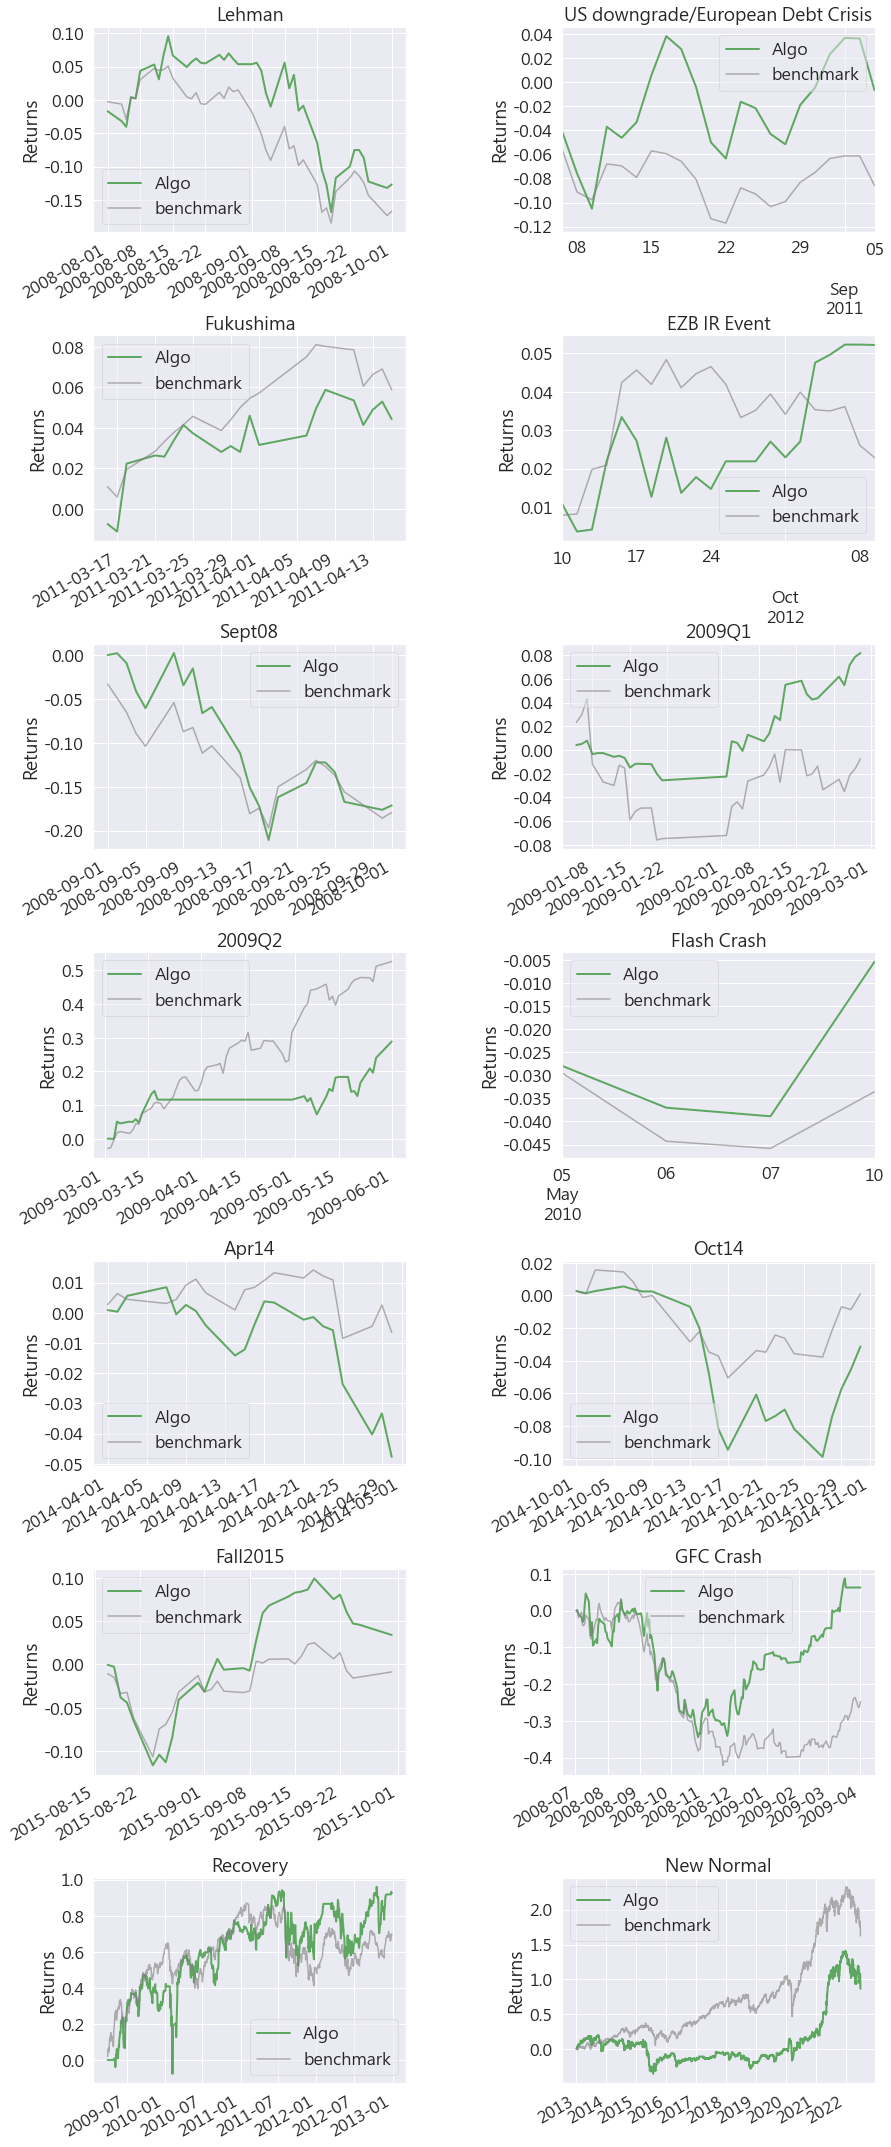

In [9]:
from pyfolio.tears import create_interesting_times_tear_sheet
create_interesting_times_tear_sheet(returns, benchmark_rets)

<span id="show_and_plot_top_positions"></span>

### pyfolio.plotting.show_and_plot_top_positions

製作多單持有量前十、空單持有量前十與綜合持有量的標的持有部位比率表格，並且繪製各時間點持有比率圖。

#### Parameters:

* returns: _pd.Series_
        交易策略的日報酬率。
* positions_alloc: _pd.DataFrame_
        個股標的的持有部位分布。
* show_and_plot: _int_, optional
        1. 若為 0，僅繪圖。
        2. 若為 1，僅製表。
        3. 若為 2，同時製作圖與表。
* hide_positions: _boolean_, optional
        若為 True，隱藏標的名稱。
* legend_loc: _plt.lengend_loc_, optional
        圖表中圖例的位置。
* ax: _matplotlib.Axes_, optional
        matplotlib 中的尺標。
        
#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

Top 10 long positions of all time,max
sid,
1101,95.52%
3443,89.21%
2451,82.23%
2206,76.92%
2337,71.73%
1201,71.08%
1701,67.30%
2303,63.97%
2388,60.60%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
1101,95.52%
3443,89.21%
2451,82.23%
2206,76.92%
2337,71.73%
1201,71.08%
1701,67.30%
2303,63.97%
2388,60.60%


<AxesSubplot:title={'center':'Portfolio allocation over time, only top 10 holdings'}, xlabel='index', ylabel='Exposure by holding'>

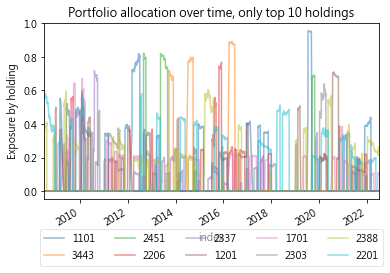

In [10]:
from pyfolio.plotting import show_and_plot_top_positions
import pyfolio
show_and_plot_top_positions(returns, positions_alloc=pyfolio.pos.get_percent_alloc(positions))

<span id="get_percent_alloc"></span>

### pyfolio.pos.get_percent_alloc

計算每日標的與現金部位比率

#### Parameters:

* values: _pd.DataFrame_ 
        標的的持有部位分布。

#### Returns:
&emsp;_pd.DataFrame_, 每日標的與現金部位比率。

[Return to Menu](#menu)

In [11]:
from pyfolio.pos import get_percent_alloc
get_percent_alloc(positions)

sid,Equity(0 [1101]),Equity(1 [1201]),Equity(2 [1701]),Equity(3 [1734]),Equity(4 [2201]),Equity(5 [2206]),Equity(6 [2303]),Equity(8 [2337]),Equity(9 [2369]),Equity(10 [2388]),Equity(11 [2451]),Equity(13 [3443]),Equity(14 [3711]),Equity(15 [4133]),Equity(16 [6770]),cash
index,,,,,,,,,,,,,,,,
2008-07-03 00:00:00+00:00,0.0,0.0,0.000000,0.0,0.597212,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.402788
2008-07-04 00:00:00+00:00,0.0,0.0,0.000000,0.0,0.593142,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.406858
2008-07-07 00:00:00+00:00,0.0,0.0,0.000000,0.0,0.589827,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.410173
2008-07-08 00:00:00+00:00,0.0,0.0,0.000000,0.0,0.584322,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.415678
2008-07-09 00:00:00+00:00,0.0,0.0,0.000000,0.0,0.586599,0.0,0.0,0.0,0.000000,0.367780,0.0,0.0,0.0,0.000000,0.000000,0.045622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-27 00:00:00+00:00,0.0,0.0,0.103864,0.0,0.000000,0.0,0.0,0.0,0.166841,0.256606,0.0,0.0,0.0,0.188929,0.207963,0.075797
2022-06-28 00:00:00+00:00,0.0,0.0,0.104365,0.0,0.000000,0.0,0.0,0.0,0.164239,0.262214,0.0,0.0,0.0,0.190271,0.202577,0.076335
2022-06-29 00:00:00+00:00,0.0,0.0,0.108819,0.0,0.000000,0.0,0.0,0.0,0.168840,0.243744,0.0,0.0,0.0,0.196411,0.203486,0.078700


<span id="plot_rolling_retruns"></span>

### pyfolio.plotting.plot_rolling_retruns

繪製出累積交易策略報酬率與指標報酬率。


#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* factor_returns: _pd.Series_, optional
        指標報酬率，通常設定為市場報酬。
* live_start_date: _datetime_, optional<br>
        回測期間之後，開始 live trading 日期，相當於區分 In-sample 與 out-of sample 檢測，預設 = None，日期必須標準化。
* logy: _boolean_, optional
        是否使用對數報酬，預設 = False。
* cone_std: _float_ or _tuple_, optional
        設定 out_of_sample 時，交易策略預期報酬率的標準差區間。
        若為 float，則設定單一標準差區間。
        若為 tuple，則設定多個標準差區間。
* legend_loc: _plt.lengend_loc_, optional
        圖表中圖例的位置。
* volatility_match: _boolean_, optional
        是否將交易策略與指標的報酬率以波動度進行標準化，以便比較相同風險下的報酬差異。
* cone_function: _function_, optional
        用來計算 out_of_sample 期間，預測報酬率的函式。
* ax: _matplotlib.Axes_, optional
        matplotlib 的尺標。

#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:ylabel='Cumulative returns'>

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


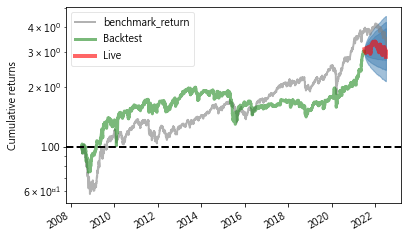

In [12]:
from pyfolio.plotting import plot_rolling_returns
plot_rolling_returns(returns,
                     benchmark_rets, 
                     live_start_date=pd.Timestamp('2021-07-03'),
                     logy=True,
                     cone_std=(1., 1.5, 2.),
                     volatility_match=True
                    )

<span id="plot_returns"></span>

### pyfolio.plotting.plot_returns

繪製每日交易策略報酬圖。

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* live_start_date: _datetime_, optional
        回測期間之後，開始 live trading 日期，相當於區分 In-sample 與 out-of sample 檢測，預設 = None，日期必須標準化。 
* ax: _matplotlib.Axes_, optional
        matplotlib 的尺標。

#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:ylabel='Returns'>

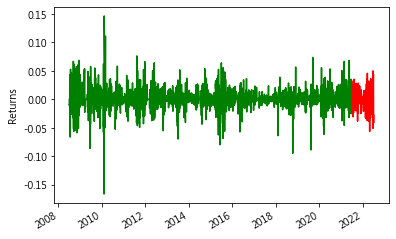

In [13]:
from pyfolio.plotting import plot_returns
plot_returns(returns, live_start_date=pd.Timestamp('2021-07-03'))

<span id="plot_rolling_beta"></span>
### pyfolio.plotting.plot_rolling_beta

繪製六個月與十二個月的移動 beta 值。

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* factor_returns: _pd.Series_
        計算 beta 所需的指標報酬率，通常設定為市場報酬。
* legend_loc: _plt.lengend_loc_, optional
        圖表中圖例的位置。
* ax: _matplotlib.Axes_, optional
        matplotlib 的尺標。
        
#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Rolling portfolio beta to benchmark_return'}, ylabel='Beta'>

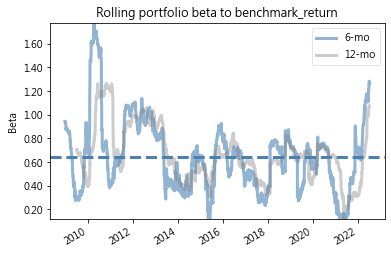

In [14]:
from pyfolio.plotting import plot_rolling_beta
plot_rolling_beta(returns, 
                  factor_returns=benchmark_rets
                 )

<span id="plot_rolling_volatility"></span>
### pyfolio.plotting.plot_rolling_volatility

繪製移動波動度圖表

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* factor_returns: _pd.Series_, optional
        計算指標波動度所需的指標報酬率，通常設定為市場報酬。
* rolling_window: _int_, optional
        計算移動波動度所需之窗格大小。
* legend_loc: _plt.lengend_loc_, optional
        圖表中圖例的位置。
* ax: _matplotlib.Axes_, optional
        matplotlib 的尺標。
        
#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Rolling volatility (6-month)'}, ylabel='Volatility'>

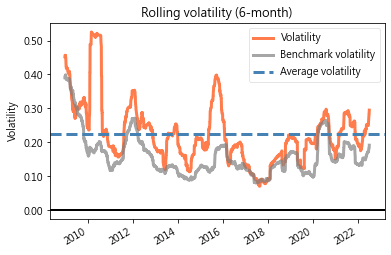

In [15]:
from pyfolio.plotting import plot_rolling_volatility
plot_rolling_volatility(returns,
                        factor_returns=benchmark_rets
                       )

<span id="plot_rolling_sharpe"></span>

### pyfolio.plotting.plot_rolling_sharpe

繪製移動波動度圖表

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* factor_returns: _pd.Series_, optional
        計算指標夏普值所需的指標報酬率，通常設定為市場報酬。
* rolling_window: _int_, optional
        計算移動波動度所需之窗格大小。
* legend_loc: _plt.lengend_loc_, optional
        圖表中圖例的位置。
* ax: _matplotlib.Axes_, optional
        matplotlib 的尺標。
        
#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Rolling Sharpe ratio (6-month)'}, ylabel='Sharpe ratio'>

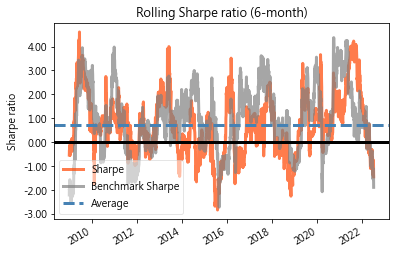

In [16]:
from pyfolio.plotting import plot_rolling_sharpe
plot_rolling_sharpe(returns,
                    factor_returns=benchmark_rets
                       )

<span id="plot_drawdown_periods"></span>

### pyfolio.plotting.plot_drawdown_periods

繪製前 n 大回撤期間於累積報酬圖。

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* top: _int_, optional
        決定 n，預設為 10。
* ax: _matplotlib.Axes_, optional
        matplotlib 的尺標。
        
#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Top 10 drawdown periods'}, ylabel='Cumulative returns'>

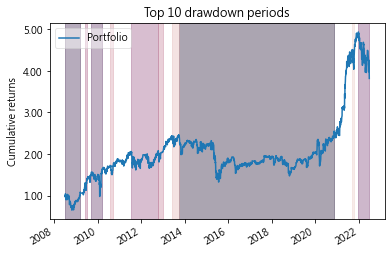

In [17]:
import pyfolio
pyfolio.plotting.plot_drawdown_periods(returns)

<span id="plot_drawdown_underwater"></span>

### pyfolio.plotting.plot_drawdown_underwater

繪製策略 underwater 程度。

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* ax: _matplotlib.Axes_, optional
        matplotlib 的尺標。
        
#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Underwater plot'}, ylabel='Drawdown'>

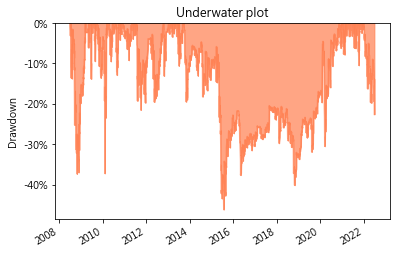

In [18]:
pyfolio.plotting.plot_drawdown_underwater(returns)

<span id="plot_monthly_returns_heatmap"></span>

### pyfolio.plotting.plot_monthly_returns_heatmap

以熱力圖繪製交易策略每月報酬。

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* ax: _matplotlib.Axes_, optional
        matplotlib 的尺標。
        
#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Monthly returns (%)'}, xlabel='Month', ylabel='Year'>

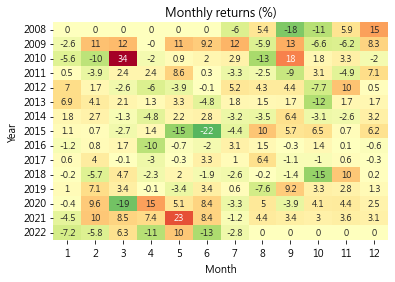

In [19]:
pyfolio.plotting.plot_monthly_returns_heatmap(returns)

<span id="plot_annual_returns"></span>

### pyfolio.plotting.plot_annual_returns

繪製交易策略每年報酬。

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* ax: _matplotlib.Axes_, optional
        matplotlib 的尺標。
        
#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Annual returns'}, xlabel='Returns', ylabel='Year'>

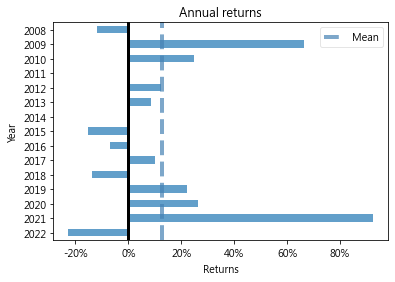

In [20]:
pyfolio.plotting.plot_annual_returns(returns)

<span id="plot_monthly_returns_dist"></span>
### pyfolio.plotting.plot_monthly_returns_dist

繪製交易策略每月報酬之分布圖。

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* ax: _matplotlib.Axes_, optional
        matplotlib 的尺標。
        
#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Distribution of monthly returns'}, xlabel='Returns', ylabel='Number of months'>

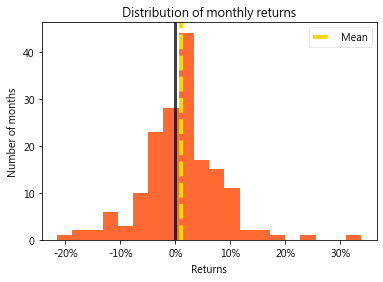

In [21]:
pyfolio.plotting.plot_monthly_returns_dist(returns)

<span id="plot_return_quantiles"></span>
### pyfolio.plotting.plot_return_quantiles

繪製交易策略日、週、月頻率的報酬盒狀圖。

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* live_start_date: _datetime_, optional
        回測期間之後，開始 live trading 日期，相當於區分 In-sample 與 out-of sample 檢測，預設 = None，日期必須標準化。
* ax: _matplotlib.Axes_, optional
        matplotlib 的尺標。
        
#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Return quantiles'}>

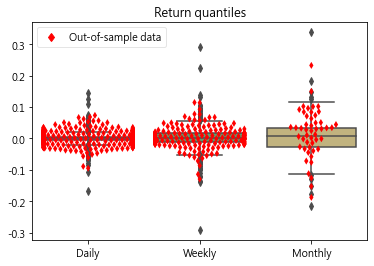

In [22]:
pyfolio.plotting.plot_return_quantiles(returns, live_start_date=pd.Timestamp("2018-07-02", tz='UTC'))

<span id="plot_exposures"></span>
### pyfolio.plotting.plot_exposures

繪製多空曝險部位圖。

    1. Long = 多頭部位總價值/所有部位總價值
    2. Short = 空頭部位總價值/所有部位總價值
    3. Net = 現金部位以外總價值/所有部位總價值

#### Parameters:

* returns: _pd.Series_
        交易策略的日報酬率。
* positions_alloc: _pd.DataFrame_
        個股標的的持有部位分布。
* ax: _matplotlib.Axes_, optional
        matplotlib 中的尺標。
        
#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Exposure'}, ylabel='Exposure'>

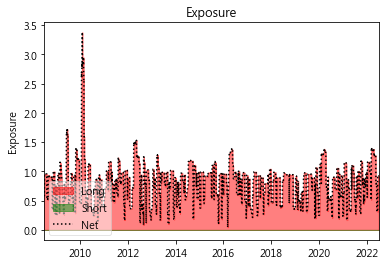

In [23]:
pyfolio.plotting.plot_exposures(returns, positions)

<span id="plot_max_median_position_concentration"></span>
### pyfolio.plotting.plot_max_median_position_concentration

繪製多空集中程度 (concentration) 的最大值與中位數。
    
    1. max_long = 多頭部位集中程度最大值
    2. max_short = 空頭部位集中程度最大值
    3. median_long = 多頭部位集中程度中位數
    4. median_short = 空頭部位集中程度中位數

#### Parameters:

* positions_alloc: _pd.DataFrame_
        個股標的的持有部位分布。
* ax: _matplotlib.Axes_, optional
        matplotlib 中的尺標。
        
#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Long/short max and median position concentration'}, xlabel='index', ylabel='Exposure'>

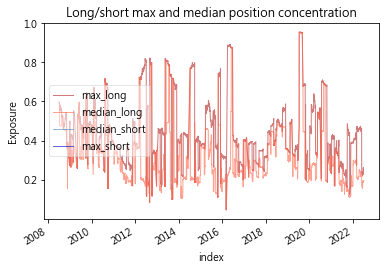

In [24]:
pyfolio.plotting.plot_max_median_position_concentration(positions)

<span id="plot_holdings"></span>
### pyfolio.plotting.plot_holdings

繪製持有股數。
1. Daily holdings: 每日持有股數
2. Average daily holdings, by month: 每月日均持有數
3. Average daily holdings, Total: 日均持有數

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* positions: _pd.DataFrame_
        每日標的與現金部位表。
* legend_loc: _plt.lengend_loc_, optional
        圖表中圖例的位置。
* ax: _matplotlib.Axes_, optional
        matplotlib 中的尺標。
        
#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Total holdings'}, ylabel='Holdings'>

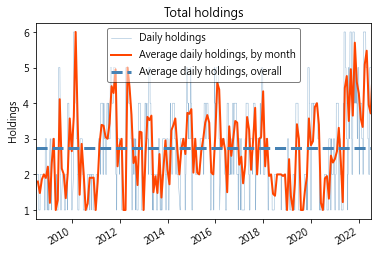

In [25]:
pyfolio.plotting.plot_holdings(returns, positions)

<span id="plot_long_short_holdings"></span>
### pyfolio.plotting.plot_long_short_holdings

繪製多空頭持有股數。

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* positions: _pd.DataFrame_
        每日標的與現金部位表。
* legend_loc: _plt.lengend_loc_, optional
        圖表中圖例的位置。
* ax: _matplotlib.Axes_, optional
        matplotlib 中的尺標。
        
#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Long and short holdings'}, ylabel='Holdings'>

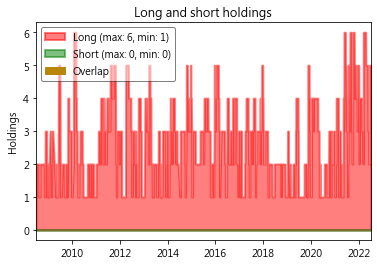

In [26]:
pyfolio.plotting.plot_long_short_holdings(returns, positions)

<span id="plot_gross_leverage"></span>
### pyfolio.plotting.plot_gross_leverage

繪製毛槓桿 (gross leverage)，gross leverage = (long exposure - short exposure)/net asset value。

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* positions: _pd.DataFrame_
        每日標的與現金部位表。
* legend_loc: _plt.lengend_loc_, optional
        圖表中圖例的位置。
* ax: _matplotlib.Axes_, optional
        matplotlib 中的尺標。
        
#### Returns:
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Gross leverage'}, ylabel='Gross leverage'>

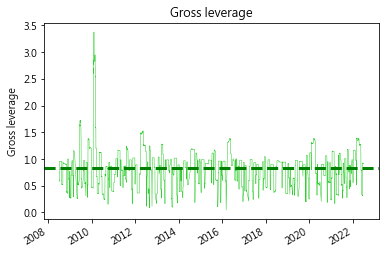

In [27]:
pyfolio.plotting.plot_gross_leverage(returns, positions)

<span id="plot_turnover"></span>

### pyfolio.plotting.plot_turnover

繪製周轉率圖，周轉率計算方法請見下方 turnover_denom。

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* transactions: _pd.DataFrame_
        交易策略的交易資料，一列為一筆交易。
* positions: _pd.DataFrame_
        每日標的與現金部位表。
* turnover_denom: _str_, optional
        周轉率計算方式，有 AGB 和 portfolio_value 兩種，預設為 AGB，
        計算方法為 (買進總額 + 賣出總額絕對值) / (AGB or portfolio_value)，
        AGB = portfolio-value - cash。
* legend_loc: _plt.lengend_loc_, optional
        圖表中圖例的位置。
* ax: _matplotlib.Axes_, optional
        matplotlib 中的尺標。

#### Returns: 
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Daily turnover'}, ylabel='Turnover'>

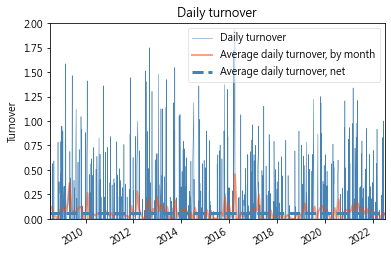

In [28]:
pyfolio.plotting.plot_turnover(returns, transactions, positions)

<span id="plot_daily_volume"></span>

### pyfolio.plotting.plot_daily_volume

繪製每日交易量。

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* transactions: _pd.DataFrame_
        交易策略的交易資料，一列為一筆交易。
* ax: _matplotlib.Axes_, optional
        matplotlib 中的尺標。

#### Returns: 
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Daily trading volume'}, ylabel='Amount of shares traded'>

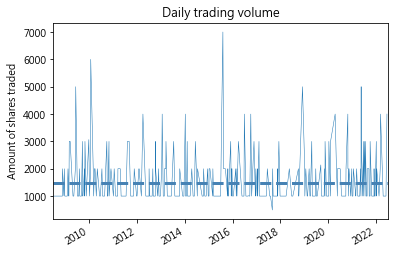

In [29]:
pyfolio.plotting.plot_daily_volume(returns, transactions)

<span id="plot_daily_turnover_hist"></span>

### pyfolio.plotting.plot_daily_turnover_hist

繪製每日周轉率分布圖，周轉率計算方法請見下方 turnover_denom。

#### Parameters:

* transactions: _pd.DataFrame_
        交易策略的交易資料，一列為一筆交易。
* positions: _pd.DataFrame_
        每日標的與現金部位表。
* turnover_denom: _str_, optional
        周轉率計算方式，有 AGB 和 portfolio_value 兩種，預設為 AGB，
        計算方法為 (買進總額 + 賣出總額絕對值) / (AGB or portfolio_value)，
        AGB = portfolio-value - cash。
* ax: _matplotlib.Axes_, optional
        matplotlib 中的尺標。

#### Returns: 
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Distribution of daily turnover rates'}, xlabel='Turnover rate', ylabel='Count'>

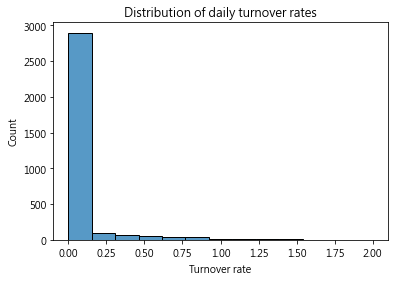

In [30]:
pyfolio.plotting.plot_daily_turnover_hist(transactions, positions)

<span id="plot_txn_time_hist"></span>
### pyfolio.plotting.plot_txn_time_hist

繪製交易時間分布圖。(僅適用於日內資料)

#### Parameters:
* transactions: _pd.DataFrame_
        交易策略的交易資料，一列為一筆交易。
* bin_minutes: _float_, optional
        時間區間間隔，預設為 5 分鐘。
* tz: _str_, optional
        時區。
* ax: _matplotlib.Axes_, optional
        matplotlib 中的尺標。
        
#### Returns: 
&emsp; _matplotlib.Axes_

[Return to Menu](#menu)

<AxesSubplot:title={'center':'Transaction time distribution'}, ylabel='Proportion'>

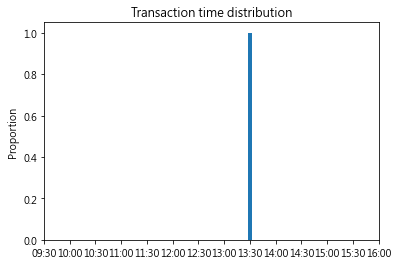

In [31]:
pyfolio.plotting.plot_txn_time_hist(transactions, tz = 'Asia/Taipei')

<span id="create_full_tear_sheet"></span>

### pyfolio.tears.create_full_tear_sheet

繪製以上所有績效與風險相關圖表。

#### Parameters:
* returns: _pd.Series_
        交易策略的日報酬率。
* positions: _pd.DataFrame_
        每日標的與現金部位表。
* transactions: _pd.DataFrame_
        交易策略的交易資料，一列為一筆交易。
* market_data: _pd.DataFrame_, optional
        每日市場資料，一日一行，欄位有股、交易量、價格，預設 = None。
* benchmark_rets: _pd.Series_, optional
        指標日報酬率，預設 = None。
* slippage: _int_ or _float_, optional 
        滑價，單位為basis point，需搭配 positions 和 transactions 使用，預設 = None，
* live_start_date: _datetime_, optional
        回測期間之後，開始 live trading 日期，相當於區分 In-sample 與 out-of sample 檢測，預設 = None，日期必須標準化。
* sector_mappings: _dict_ or _pd.Series_, optional
        行業分類，以股票 SID 為 key，行業為 value 的字典或 pd.Series，預設 = None。
* round_trips: _boolean_, optional
        交易 round trip 表格，需要搭配positions和transactions使用，預設 = False。
* estimate_intraday: _boolean_ or _str_, optional
        估算日內交易，預設為'infer'。
* hide_positions: _boolean_, optional
        隱藏股票代碼，預設為 False。
* cone_std: _float_ or _tuple_, optional
        設定 out_of_sample 時，交易策略預期報酬率的標準差區間。
        若為 float，則設定單一標準差區間。
        若為 tuple，則設定多個標準差區間。
* bootstrap: _boolean_, optional
        對各項指標進行拔靴法測試，預設 = False。
* unadjusted_returns: _pd.Series_, optional
        調整前日報酬率，預設 = None，提供後會額外繪製:
        1. Cumulative returns given additional per-dollar slippage
        2. Average annual returns given additional per-dollar slippage
* turnover_denom: _str_, optional
        周轉率計算方式，有 AGB 和 portfolio_value 兩種，預設為 AGB，
        計算方法為 (買進總額 + 賣出總額絕對值) / (AGB or portfolio_value)，
        AGB = portfolio-value - cash。
* set_context: _boolean_, optional
        設置繪圖風格。
* header_rows: _dict_ or _OrderedDict_, optional
        在表格 start date yyyy-mm-dd 上額外增加列，預設為 None。
* factor_returns: _pd.DataFrame_, optional
        風險因子所歸屬的報酬率，以日期作為指標，因子作為欄位。
        Ex:
                        momentum  reversal
            2017-01-01  0.002779 -0.005453
            2017-01-02  0.001096  0.010290       
* factor_loadings: _pd.DataFrame_, optional
        因子負荷量，為因子所對應的係數，以日期與標的為指標，因子為欄位。
        Ex:
                               momentum  reversal
            dt         ticker
            2017-01-01 AAPL   -1.592914  0.852830
                       TLT     0.184864  0.895534
                       XOM     0.993160  1.149353
            2017-01-02 AAPL   -0.140009 -0.524952
                       TLT    -1.066978  0.185435
                       XOM    -1.798401  0.761549
* pos_in_dollars: _boolean_, optional
        若為 True，positions 內欄位單位為元 (dollar)。
        若為 False，positions 內欄位單位為比率 (percentage)。 
* factor_partitions: _dict_, optional
        用於繪製報酬歸屬於因子圖。
        Ex: 
          {'style': ['momentum', 'size', 'value', ...],
           'sector': ['technology', 'materials', ... ]}

[Return to Menu](#menu)

Start date,2008-07-02
End date,2022-07-01
Total months,164
,Backtest
Annual return,10.279%
Cumulative returns,281.876%
Annual volatility,25.041%
Sharpe ratio,0.52
Calmar ratio,0.22
Stability,0.47
Max drawdown,-46.209%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,46.21,2013-09-25,2015-07-28,2020-11-16,1752
1,37.37,2008-07-11,2008-10-27,2009-03-16,167
2,37.25,2009-09-18,2010-02-06,2010-03-11,118
3,22.63,2021-12-30,2022-07-01,NaT,NaN
4,21.55,2011-07-20,2011-10-05,2012-10-16,312


Stress Events,mean,min,max
Lehman,-0.28%,-5.62%,6.69%
US downgrade/European Debt Crisis,0.02%,-4.62%,7.63%
Fukushima,0.21%,-1.38%,3.39%
EZB IR Event,0.24%,-1.42%,2.00%
Sept08,-0.80%,-5.62%,6.69%
2009Q1,0.23%,-1.13%,3.04%
2009Q2,0.42%,-3.73%,5.37%
Flash Crash,-0.11%,-2.80%,3.49%
Apr14,-0.23%,-1.80%,0.84%
Oct14,-0.13%,-3.55%,3.73%


Top 10 long positions of all time,max
sid,
1101,95.52%
3443,89.21%
2451,82.23%
2206,76.92%
2337,71.73%
1201,71.08%
1701,67.30%
2303,63.97%
2388,60.60%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
1101,95.52%
3443,89.21%
2451,82.23%
2206,76.92%
2337,71.73%
1201,71.08%
1701,67.30%
2303,63.97%
2388,60.60%


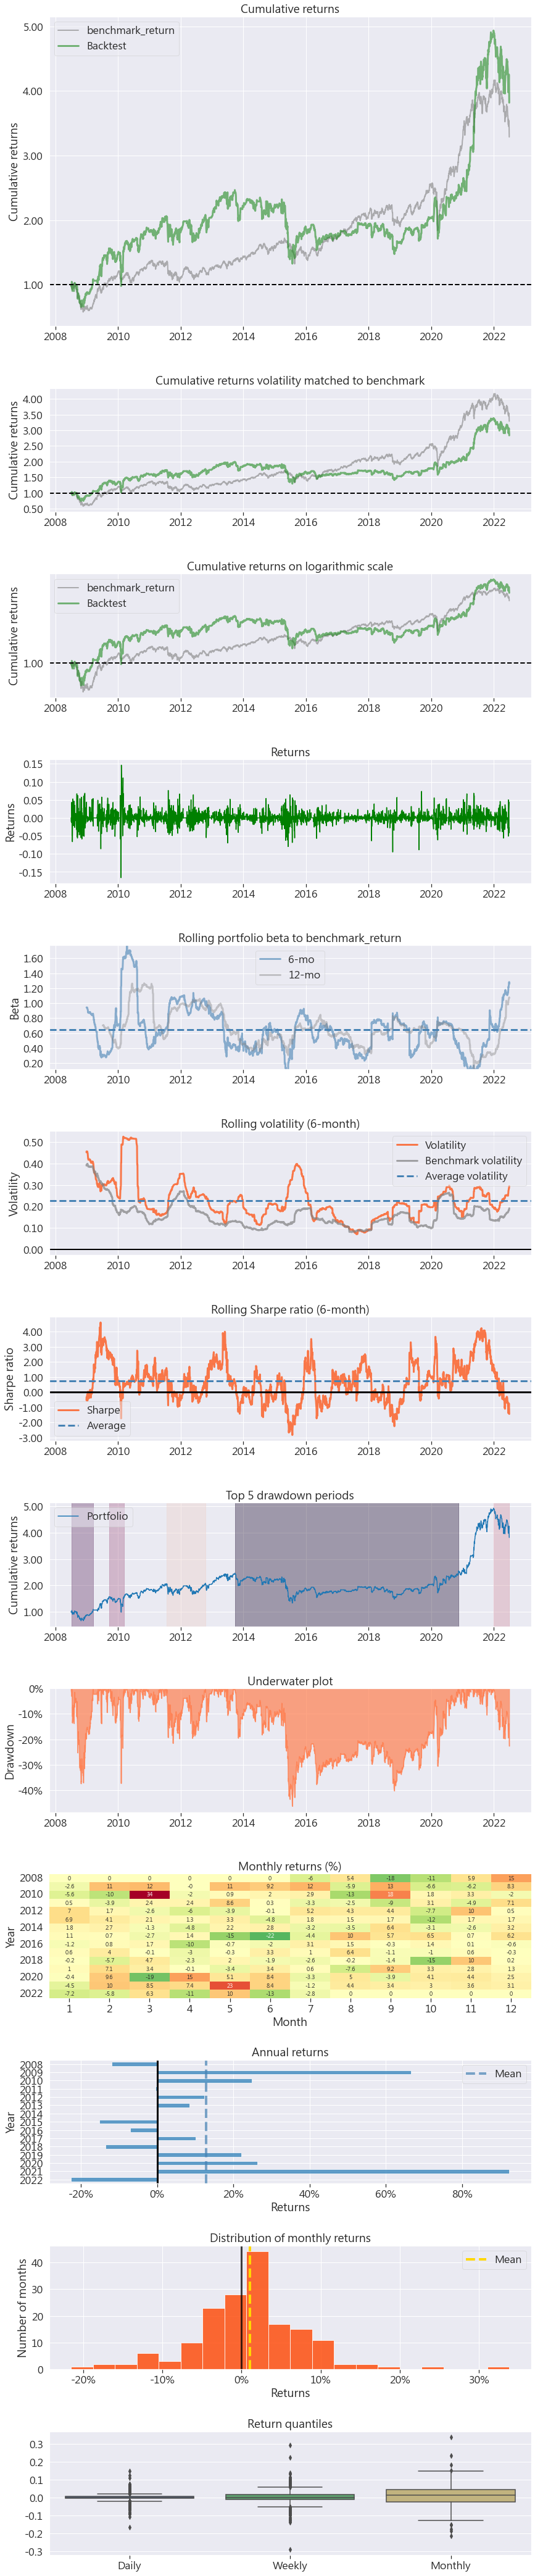

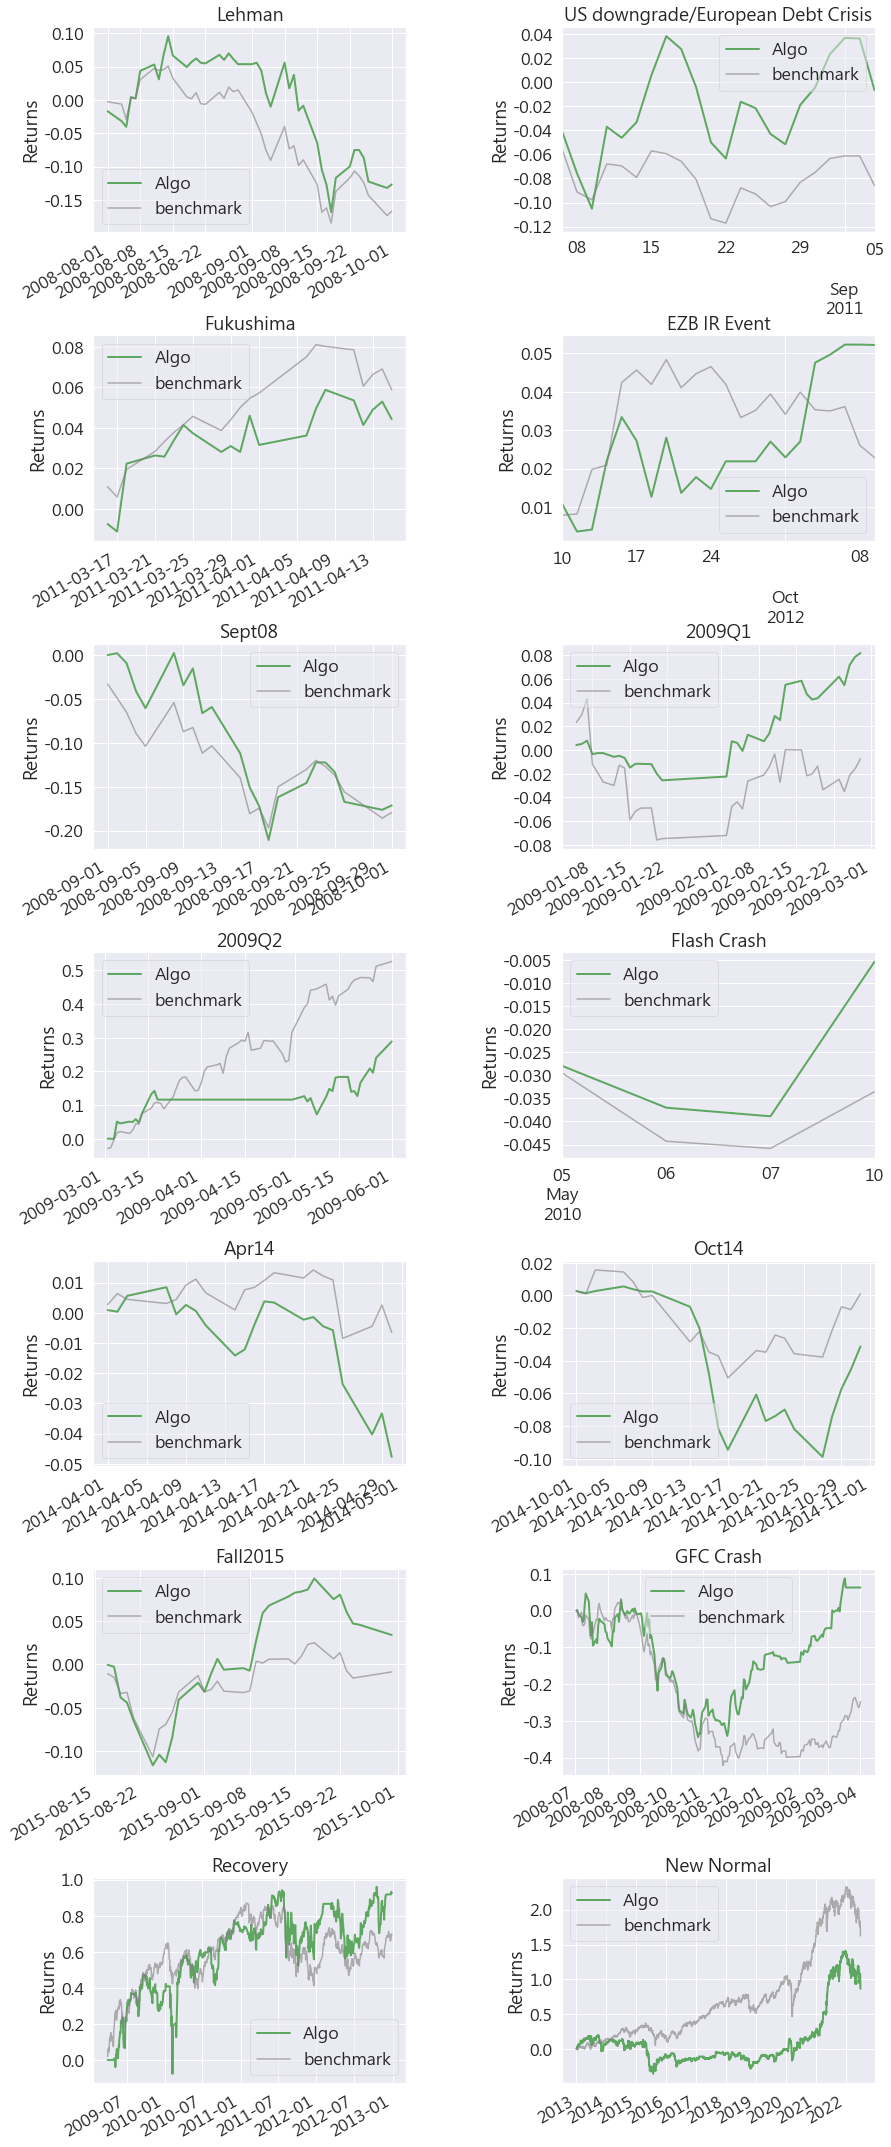

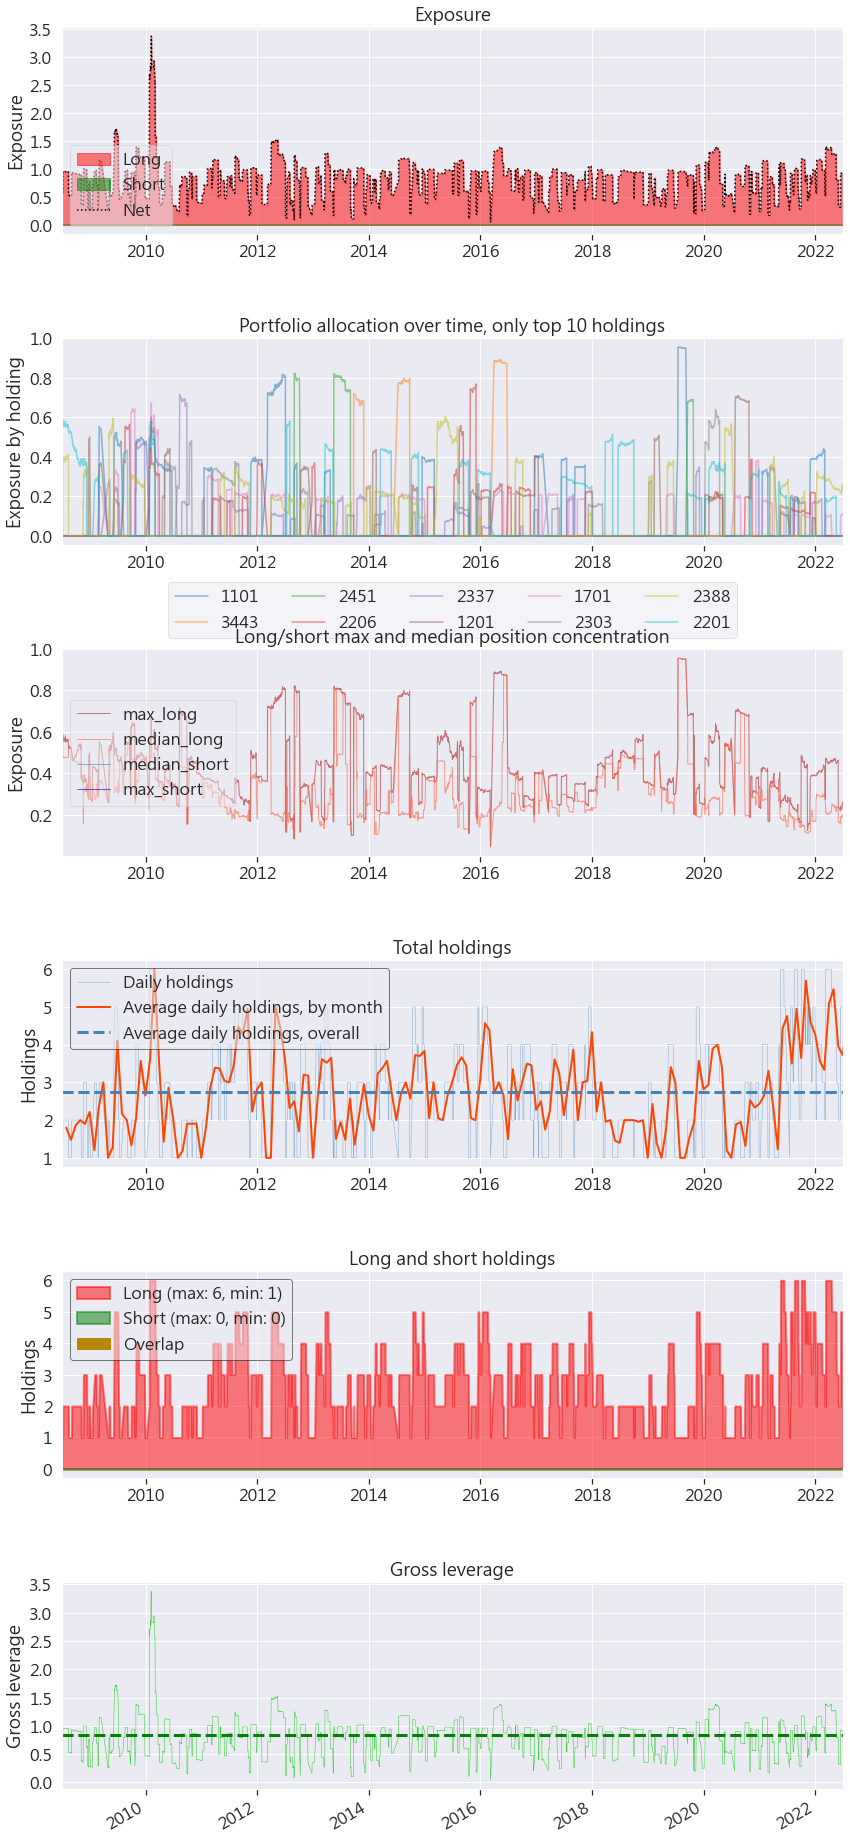

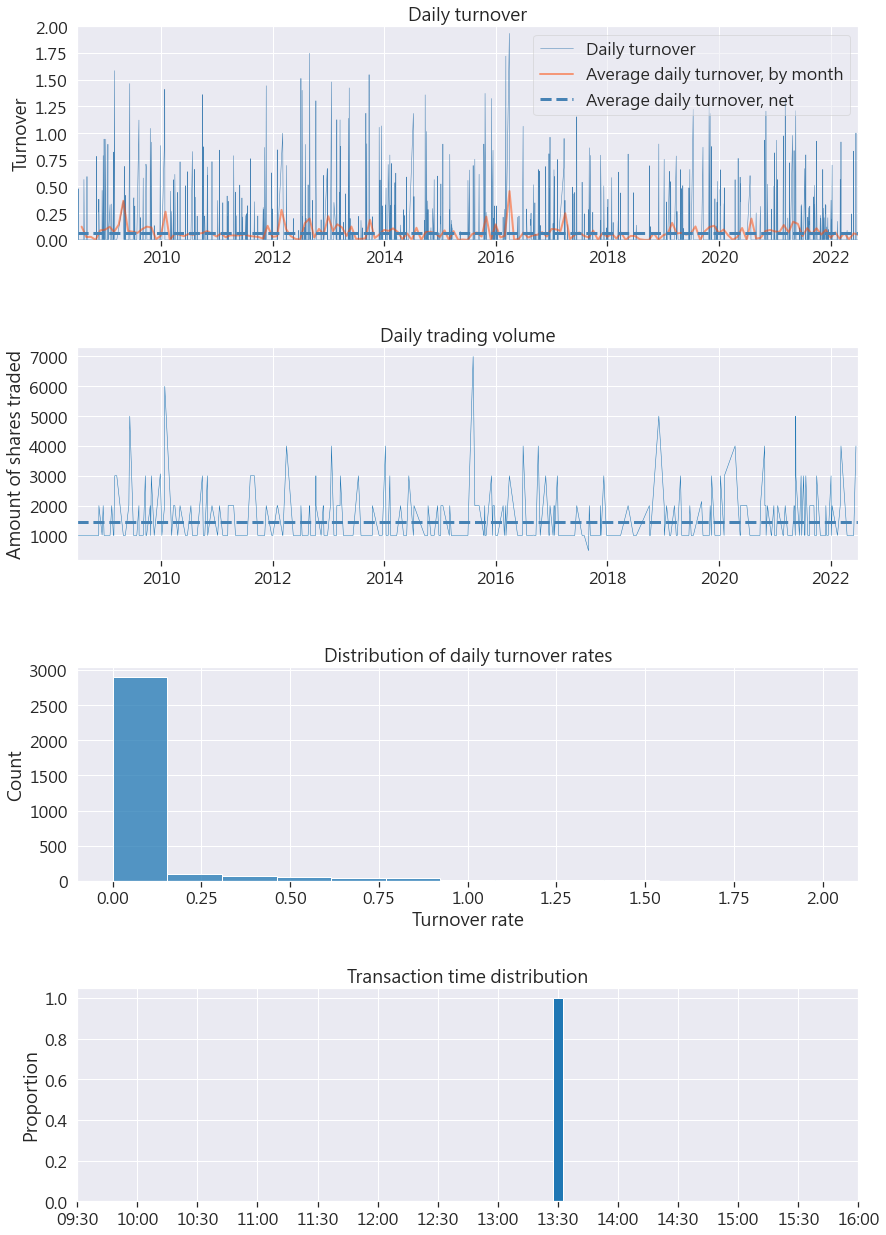

In [32]:
pyfolio.tears.create_full_tear_sheet(returns=returns,
                                     positions=positions,
                                     transactions=transactions,
                                     benchmark_rets=benchmark_rets
                                    )